<a href="https://colab.research.google.com/github/PlaZMaD/ml_miem_2024/blob/main/Seminar_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 3. Предобработка данных


Если чувствуете, что не хватает подготовки для нашего курса, не теряйтесь и говорите, что именно сложно и непонятно.
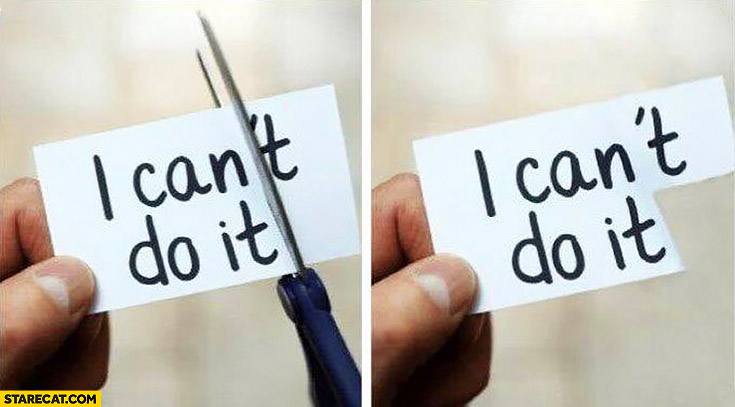

## GitHub
* К следующему занятию заведите аккаунт на [GitHub](https://github.com/)

На прошлых двух семинарах мы рассмотрели основные способы работы с данными в `python`
* Вспомнили необходимые сведения массивах
* Вспомнили как работать со случайными числами
* Научились устанавливать и использовать некоторые библиотеки:
  * `numpy` - для быстрых вычислений и линейной алгебры
  * `pandas` - работа с табличными данными, простые манипуляции с данными без циклов
  * `seaborn` - набор готовых решений для визуализации данных
  * `matplotlib` - набор "низкоуровневых" средств для визуализации данных

In [ ]:
# Загрузим необходимые библиотеки:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns, statsmodels.api as sm

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, accuracy_score
from sklearn.linear_model import SGDClassifier

from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

# Предобработка данных
Рассмотрим датасет с пассажирами "Титаника".

In [ ]:
csv_url = 'https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv'
df = pd.read_csv(csv_url)
df.head()

В датасете есть следующие признаки для каждого пассажира:

 - `Survived` - целевая переменная (1 = пассажир выжил).
 - `Pclass` - класс билета (1 = перый, 2 = второй, 3 = третий)
 - `Name` - имя
 - `Sex` - пол
 - `Age` - возраст
 - `SibSp` - число братьев/сестёр/партнёров на борту "Титаника"
 - `Parch` - число родителей/детей на борту "Титаника"
 - `Ticket` - номер билета
 - `Fare` - тариф билета
 - `Cabin` - номер каюты
 - `Embarked` - порт посадки на борт (C = Cherbourg, Q = Queenstown, S = Southampton)

Используя методы `.info` and `.describe` на датафрейме, можно заметить:
* Признак `Sex` и целевая переменная `Survived` бинарные
* `Сabin` содержит в основном пропущенные значения, несколько `NaN` значений есть также в `Age`
* `SibSp`, `Parch` и `Fare` имеют значительный разброс вокруг их средних значений - нужно отдельно рассмотреть выбросы (`outliers`)
* `Ticket` - числовые значения и иногда цифро-буквенные коды


In [ ]:
df.info() # типы и размеры данных

In [ ]:
df.describe() # статистические сведения для числовых данных

In [ ]:
df.describe(include=['O']) # и объектов тоже

Мы можем получить индивидуальные значения признаков и частоты для категориальных столбцов с помощью функции `pd.value_counts`:

In [ ]:
for feature in ['Survived', 'Pclass', 'Sex', 'Embarked']:
    print("Statistics for feature", feature)
    print(pd.value_counts(df[feature], normalize=True))
    print("")

Наблюдается перекос в сторону мужского пола, и большинство пассажиров, по-видимому, садились в порту Саутгемптона.

Также мы видим, что есть небольшой дисбаланс в целевой переменной.

Крайне важно изучить распределение целевых переменных в задаче классификации!

Например, если доля выживших пассажиров близка к 95%, это говорит о том, что даже самая простая модель, возвращающая 1 независимо от входных данных, получит точность 95%. Следовательно, эта метрика по умолчанию не подходит для измерения производительности модели, и нам нужно выбрать другую.

В наших данных это не так - поэтому мы можем смело измерять эффективность модели с помощью `accuracy`.

In [ ]:
plt.figure(figsize=(14, 8))
ax = sns.heatmap(df.corr(), annot=True)

In [ ]:
sns.barplot(x=df['Pclass'], y=df['Survived'])
plt.title('Ratio of survivors per class')

In [ ]:
sns.barplot(x=df['Embarked'], y=df['Survived'])
plt.title('Ratio of survivors per embarktion port')

Отфильтруем датасет:

In [ ]:
plt.hist(df["Age"]);

In [ ]:
df["Age"].median()

In [ ]:
df.describe()

In [ ]:
df_filtered = df.drop(['Cabin', 'Ticket', 'Name'], axis=1)

df_filtered["emb_is_S"] = (df_filtered["Embarked"] == "S").astype(int)
df_filtered["emb_is_C"] = (df_filtered["Embarked"] == "C").astype(int)

median_age = df_filtered["Age"].median()

print("Filling NaN values with Age", median_age)

df_filtered = df_filtered.fillna(median_age)

df_filtered['Sex'] = df['Sex'].replace(['female','male'],[1,0])

df_filtered = df_filtered.drop(["Embarked"], axis=1)

df_filtered.head()

In [ ]:
sns.boxplot(data=df_filtered)
plt.ylim(0, 100)

In [ ]:
# Обработаем статистические выбросы:
fare_max = df_filtered['Fare'].quantile(0.95)
age_max = df_filtered['Age'].quantile(0.95)
df_filtered.loc[df_filtered['Fare'] > fare_max, "Fare"] = fare_max
df_filtered.loc[df_filtered['Age'] > age_max, "Age"] = age_max

In [ ]:
sns.boxplot(data=df_filtered)
plt.ylim(0, 100)

# Логистическая регрессия

(использованы материалы курса [Машинное обучение в Питоне](https://www.hse.ru/edu/courses/450323352))

Логистическая регрессия - это модель **классификации**. Она тесно связана с линейной регрессией. Для некоторых меток класса $y \in \{0, 1\}$ и некоторых признаков $X$ логистическая регрессия выражает вероятность $Pr(y=1 | X)$.
В случае с датасета "Титаник" метками класса являются: 1 - выжил, 0 - нет. Это типичная задача бинарной классификации.

Модель:
$$p(x) = \frac{e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }}{1 + e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }} = sigmoid(\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots)$$

Модель представляет собой [сигмоид](https://en.wikipedia.org/wiki/Sigmoid_function), примененный к выходу линейной модели.

Выход линейной модели называется [*log-odds*](https://en.wikipedia.org/wiki/Logit) (также *logits*) $$\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots = log(\frac{p(x)}{1-p(x)})$$

Сигмоид превращает логарифмические коэффициенты (выход линейной модели) в вероятности, поэтому выход модели всегда находится в диапазоне $[0, 1]$.

Логистическая регрессия не подгоняется с помощью *МНК*, а оценивается по максимальному правдоподобию путем оптимизации [отрицательного логарифмического правдоподобия ](https://towardsdatascience.com/log-loss-function-math-explained-5b83cd8d9c83). Обычно оптимизация выполняется с помощью *градиентного спуска*.

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function
z = np.linspace(-10,10,100)
plt.plot(z, logistic(z))
plt.title('logistic function')
plt.grid()

In [ ]:
# Выделим в датасете 30% наблюдений для тестовой выборки:
X_train, X_test, y_train, y_test = tts(
    df_filtered.drop(["Survived"], axis=1), df_filtered["Survived"], test_size=0.3,
    random_state=0
)

print("Train: input shape is ", X_train.shape, "output shape is ", y_train.shape)
print("Test: input shape is ", X_test.shape, "output shape is ", y_test.shape)
print("Unique values of targets (should be 0 or 1):", np.unique(y_train))

In [ ]:
# Выберем модель логистической регрессии:
mdl = sm.Logit(y_train, sm.add_constant(X_train))
fmdl = mdl.fit()

pr_test_scores = fmdl.predict(sm.add_constant(X_test))
y_predicted = (pr_test_scores > 0.5)

print("Trained accuracy score is %.3f" % accuracy_score(y_test, y_predicted))

In [ ]:
print(fmdl.summary())

In [ ]:
?fmdl.summary

In [ ]:
pr_test_scores = fmdl.predict(sm.add_constant(X_test))
y_predicted = (pr_test_scores > 0.5)
print("Accuracy score for threshold 0.5 is %.3f" % accuracy_score(y_test, y_predicted))
print("Accuracy score for threshold 0.1 is %.3f" % accuracy_score(y_test, (pr_test_scores > 0.1)))
print("Accuracy score for threshold 0.9 is %.3f" % accuracy_score(y_test, (pr_test_scores > 0.9)))
print("Accuracy score for threshold 0.7 is %.3f" % accuracy_score(y_test, (pr_test_scores > 0.6)))

In [ ]:
thresholds = np.linspace(0, 1, 100)
accuracies = [accuracy_score(y_test, (pr_test_scores > x)) for x in thresholds]
accuracies = np.array(accuracies)

plt.figure()
plt.plot(thresholds, accuracies)
plt.title('Accuracy for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def forward_selected(X_train, y_train, X_test, y_test,
                     n_max_features=3, criteria='aic'):
    """Linear model designed by forward selection.
    Parameters:
    -----------
    Returns:
    --------
    model: an "optimal" fitted statsmodels logit model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(X_train.columns)
    selected = []
    current_score, best_new_score = -10**6, -10**6

    while (remaining and current_score == best_new_score) and (len(selected) < n_max_features):

        scores_with_candidates = []
        for candidate in remaining:

            current_features = selected + [candidate]
            mdl = sm.Logit(y_train, sm.add_constant(X_train[current_features]))
            fmdl = mdl.fit(disp=0)

            if criteria == 'accuracy':
              pr_test_scores = fmdl.predict(sm.add_constant(X_test[current_features]))
              y_predicted = (pr_test_scores > 0.5)
              score = accuracy_score(y_test, y_predicted)

            elif criteria == 'aic': score = -fmdl.aic
            scores_with_candidates.append((score, candidate))

        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()

        if current_score <= best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score

            print("# features selected = {}, score = {:.8f}".format(len(selected), current_score))
            print("Selected features: ", selected)
            print('')
    model = sm.Logit(y_train, sm.add_constant(X_train[selected])).fit(disp=0)
    return model

best_model = forward_selected(X_train, y_train, X_test, y_test,
                              n_max_features=10, criteria='accuracy')
print(best_model.summary())

In [ ]:
best_model = forward_selected(X_train, y_train, X_test, y_test,  n_max_features=10, criteria='aic')
features = [name for name in best_model.model.exog_names if name != 'const']

pr_test_scores = best_model.predict(sm.add_constant(X_test[features]))
y_predicted = (pr_test_scores > 0.5)
score = accuracy_score(y_test, y_predicted)

print("Trained accuracy score is %.3f" % accuracy_score(y_test, y_predicted))
print('')
print(best_model.summary())

In [ ]:
x_var = 'Age'

idx_drop = ((X_train.loc[:, x_var] < 40) & (y_train == 1)) | ((X_train.loc[:, x_var] > 70) & (y_train == 0))

xx_train = X_train.loc[~idx_drop, x_var].values.reshape(-1, 1)
x_grid = np.linspace(xx_train.min(), xx_train.max(), 100).reshape(-1, 1)

# Логистическая регрессия
mdl = sm.Logit(y_train[~idx_drop], sm.add_constant(xx_train))
fmdl = mdl.fit(disp=0)
pr_test_logit = fmdl.predict(sm.add_constant(x_grid))

plt.plot(x_grid, pr_test_logit, color='green', label='Логистическая регрессия')

# Линейная регрессия
mdl = sm.OLS(y_train[~idx_drop], sm.add_constant(xx_train))
fmdl = mdl.fit()
pr_test_linreg = fmdl.predict(sm.add_constant(x_grid))
plt.plot(x_grid, pr_test_linreg, color='blue', label='Линейная регрессия');

plt.axhline(0.5, color='r', linewidth=2, label='Порог выбора');
plt.scatter(xx_train, y_train[~idx_drop], c='r');
plt.legend();
plt.show();